In [1]:
import numpy as np
import pandas as pd
import string
import nltk
import typing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D, Conv1D, MaxPool1D, SimpleRNN, Bidirectional, Reshape, Conv2D, MaxPooling2D
from gensim.models import Word2Vec
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers


In [2]:
# read the data
data_dir = "Cell_Phones_and_Accessories_5.json"
df = pd.read_json(data_dir, lines=True)

# delete duplicates
df = df.astype(str)
duplicates = df.duplicated()
print("Number of duplicate values:", duplicates.sum())

df = df.drop(['reviewerID', 'asin', 'reviewerName', 'helpful', 'summary', 'unixReviewTime', 'reviewTime'], axis=1)

# Filter out reviews with more than 200 words
df = df[df['reviewText'].apply(lambda x: len(x.split()) <= 200)]

# balance the score
rating_counts = df['overall'].value_counts()
min_count = rating_counts.min()

# check for null values
df['reviewText'].isnull().sum()

balanced_df = df.groupby('overall').apply(lambda x: x.sample(n=min_count, random_state=1)).reset_index(drop=True)
shuffled_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)
shuffled_df.to_json('balanced_reviews.json', orient='records', lines=True)

Number of duplicate values: 0


In [3]:
train_df, test_df = train_test_split(shuffled_df, test_size=0.3, random_state=42)

In [4]:
# printing some reviews to see insights.
for review in df['reviewText'][:5]:
    print(review+'\n'+'\n')

They look good and stick good! I just don't like the rounded shape because I was always bumping it and Siri kept popping up and it was irritating. I just won't buy a product like this again


These stickers work like the review says they do. They stick on great and they stay on the phone. They are super stylish and I can share them with my sister. :)


These are awesome and make my phone look so stylish! I have only used one so far and have had it on for almost a year! CAN YOU BELIEVE THAT! ONE YEAR!! Great quality!


Item arrived in great time and was in perfect condition. However, I ordered these buttons because they were a great deal and included a FREE screen protector. I never received one. Though its not a big deal, it would've been nice to get it since they claim it comes with one.


awesome! stays on, and looks great. can be used on multiple apple products.  especially having nails, it helps to have an elevated key.




In [5]:
from gensim.models import KeyedVectors
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
import nltk

# separate words
train_df['tokenized'] = train_df['reviewText'].apply(lambda x: word_tokenize(x.lower()))
test_df['tokenized'] = test_df['reviewText'].apply(lambda x: word_tokenize(x.lower()))

# train Word2Vec model
word2vec_model = Word2Vec(sentences=train_df['tokenized'], vector_size=200, window=5, min_count=1, workers=4)


In [6]:
# tokenizing
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(train_df['reviewText'])

X_train_seq = tokenizer.texts_to_sequences(train_df['reviewText'])
X_test_seq = tokenizer.texts_to_sequences(test_df['reviewText'])

# padding
max_len = 200
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

# label
y_train = train_df['overall'].apply(lambda x: int(x) - 1)
y_test = test_df['overall'].apply(lambda x: int(x) - 1)

In [7]:
embedding_dim = 200
word_index = tokenizer.word_index

# build embeding matrix
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    if word in word2vec_model.wv:
        embedding_matrix[i] = word2vec_model.wv[word]
print(embedding_matrix)

[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-1.29304135e+00  5.87491751e-01  4.11231101e-01 ...  3.11293453e-01
   3.02421421e-01 -2.45574474e-01]
 [ 2.29285717e-01  2.03365192e-01 -1.24748707e+00 ... -2.46774361e-01
   6.16172671e-01 -6.03508830e-01]
 ...
 [ 9.85456817e-03  4.84694308e-03  1.34307817e-02 ... -6.70009479e-03
  -9.08466754e-04  3.94437183e-03]
 [ 1.11240642e-02 -2.46007228e-03 -6.48981426e-03 ... -3.88533995e-03
  -7.21555762e-03 -1.27085075e-02]
 [ 5.11840265e-03  6.09438494e-03 -7.13858893e-03 ... -1.76486801e-02
   1.06230602e-02  9.20460152e-04]]


In [8]:
# LSTM
regr_model = Sequential([
    Embedding(input_dim=len(word_index) + 1, 
              output_dim=embedding_dim, 
              weights=[embedding_matrix], 
              input_length=max_len, 
              trainable=False),
    # Conv1D(filters=16, kernel_size = 3, strides= 2, activation="relu", 
    #        kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4), bias_regularizer=regularizers.L2(1e-4)),
    # Conv1D(filters=8, kernel_size = 3, strides= 2, activation="relu", 
    #        kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4), bias_regularizer=regularizers.L2(1e-4)),
    LSTM(20, dropout=0.2, recurrent_dropout=0.2, return_sequences = True,
         kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4), bias_regularizer=regularizers.L2(1e-4)),
    LSTM(20, dropout=0.2, recurrent_dropout=0.2, 
         kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4), bias_regularizer=regularizers.L2(1e-4)),
    Dense(1, activation='linear')
])

early_stopping = EarlyStopping(
    monitor='val_loss',  # Quantity to be monitored.
    min_delta=0,  # Minimum change in the monitored quantity to qualify as an improvement.
    patience=5,  # Number of epochs with no improvement after which training will be stopped.
    verbose=1,  # Verbosity mode, 0 or 1.
    mode='auto',  # One of {"auto", "min", "max"}.
    baseline=None,  # Baseline value for the monitored quantity to be compared with the loss.
    restore_best_weights=True  # Whether to restore model weights from the epoch with the best value of the monitored quantity.
)

regr_model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])
regr_model.summary()

# training
history = regr_model.fit(X_train_pad, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks = [early_stopping])

C:\Users\Admin\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │       5,368,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,368,000 (20.48 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 5,368,000 (20.48 MB)

Epoch 1/100
859/859 ━━━━━━━━━━━━━━━━━━━━ 125s 140ms/step - loss: 1.9961 - mae: 1.1596 - val_loss: 1.1711 - val_mae: 0.8573
Epoch 2/100
859/859 ━━━━━━━━━━━━━━━━━━━━ 121s 141ms/step - loss: 1.2114 - mae: 0.8787 - val_loss: 1.0285 - val_mae: 0.8010
Epoch 3/100
859/859 ━━━━━━━━━━━━━━━━━━━━ 131s 153ms/step - loss: 1.0958 - mae: 0.8259 - val_loss: 1.0111 - val_mae: 0.7847
Epoch 4/100
859/859 ━━━━━━━━━━━━━━━━━━━━ 135s 157ms/step - loss: 1.0300 - mae: 0.7941 - val_loss: 0.9220 - val_mae: 0.7401
Epoch 5/100
859/859 ━━━━━━━━━━━━━━━━━━━━ 132s 154ms/step - loss: 1.0055 - mae: 0.7784 - val_loss: 0.9200 - val_mae: 0.7322
Epoch 6/100
859/859 ━━━━━━━━━━━━━━━━━━━━ 143s 166ms/step - loss: 0.9483 - mae: 0.7550 - val_loss: 0.9039 - val_mae: 0.7330
Epoch 7/100
859/859 ━━━━━━━━━━━━━━━━━━━━ 109s 127ms/step - loss: 0.9284 - mae: 0.7444 - val_loss: 0.8917 - val_mae: 0.7223
Epoch 8/100
859/859 ━━━━━━━━━━━━━━━━━━━━ 104s 121ms/step - loss: 0.9353 - mae: 0.7473 - val_loss: 0.8587 - val_mae: 0.7092
Epoch 9/100
859/


KeyboardInterrupt



In [9]:
y_pred = regr_model.predict(X_test_pad)
y_pred_classes = [max(0, min(4, np.round(y[0]))) for y in y_pred]

461/461 ━━━━━━━━━━━━━━━━━━━━ 19s 40ms/step


Accuracy: 0.4527981526759033


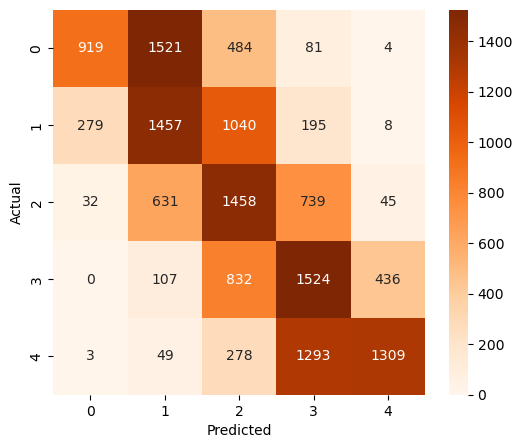

Off by one accuracy: 0.9126596033686498


In [10]:
accuracy = accuracy_score(y_test, y_pred_classes)
print("Accuracy:", accuracy)

cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, cmap='Oranges', fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

off_by_one = np.mean(np.abs(np.array(y_test) - np.array(y_pred_classes)) <= 1)
print("Off by one accuracy:", off_by_one)